# Simulation and visualization of 3D waveguides in MEEP

##  Strip waveguide

In [1]:
import meep as mp
print(mp.__version__)
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt
from IPython.display import Video

1.27.0


In [2]:
seed = np.random.randint(100000)
np.random.seed(seed)
mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)
Air = mp.Medium(index=1.0)




waveguide_width = 0.5 # (μm)
waveguide_length = 6 # (μm)
waveguide_thickness = 0.22

arm_separation =waveguide_width+ 0.5 # (μm) distance between arms center to center

air_cladding=200 # just some large value
soi_cladding=200


pml_size = 0.5 # (μm)
resolution = 50 # (pixels/μm)

In [3]:
minimum_length = 0.09 # (μm)
eta_e = 0.75

eta_i = 0.5
eta_d = 1-eta_e
design_region_resolution = int(resolution) # (pixels/μm)
frequencies = 1/np.linspace(1.5,1.6,5) # (1/μm)


In [4]:
Sx = 2*pml_size + waveguide_length # cell size in X
#Sy = 2*pml_size + 2*waveguide_width+ arm_separation +1 # cell size in Y
Sy = 2*pml_size + waveguide_width +1 # cell size in Y

Sz = 2*pml_size + waveguide_thickness +1 # cell size in Z ###

cell_size = mp.Vector3(Sx,Sy,Sz)

pml_layers = [mp.PML(pml_size)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
#source_center  = [-Sx/2 + pml_size + waveguide_length/3,arm_separation/2,0]
#source_size    = mp.Vector3(0,waveguide_width+0.5,waveguide_thickness+0.5)###
#source_size = mp.Vector3(0,2*waveguide_width,2*waveguide_thickness)
source_size= mp.Vector3(0,Sy-2*pml_size,Sz-2*pml_size)
kpoint = mp.Vector3(1,0,0)

#source_center1  = [-Sx/2 + pml_size + 0.1 ,arm_separation/2,0]

source_center1  = [-Sx/2 + pml_size + 0.1 ,0,0]
source_center2  = [-Sx/2 + pml_size + 0.1,-arm_separation/2,0]

# src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
# sources = [mp.EigenModeSource(src,
#                     eig_band = 1,
#                     direction=mp.NO_DIRECTION,
#                     eig_kpoint=kpoint,
#                     size = source_size,
#                     center=source_center1,
#                     amplitude=1.0),
#             mp.EigenModeSource(
#                     src,
#                     eig_band=1,
#                     direction=mp.NO_DIRECTION,
#                     eig_kpoint=kpoint,
#                     size=source_size,
#                     center=source_center2,
#                     amplitude=0.0 - 1.0j
#     )]


source=[mp.EigenModeSource(mp.ContinuousSource(fcen, fwidth=fwidth), center=source_center1, size=source_size, eig_band=1,direction=mp.NO_DIRECTION,eig_kpoint=kpoint)]




geometry=[]

# the top and bottom cladding
geometry.append(mp.Block(center=mp.Vector3(0, 0, -(waveguide_thickness+soi_cladding)/2), material=SiO2, size=mp.Vector3(mp.inf, mp.inf, soi_cladding))) #Oxide layer
geometry.append(mp.Block(center=mp.Vector3(0, 0, (-waveguide_thickness+air_cladding)/2), material=Air, size=mp.Vector3(mp.inf, mp.inf, air_cladding))) #the air cladding

# the waveguides
geometry.append(mp.Block(center=mp.Vector3(), material=Si, size=mp.Vector3(mp.inf, waveguide_width, waveguide_thickness))) # top left waveguide


sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution,
                    eps_averaging = True,)

  

<Axes: xlabel='X', ylabel='Y'>

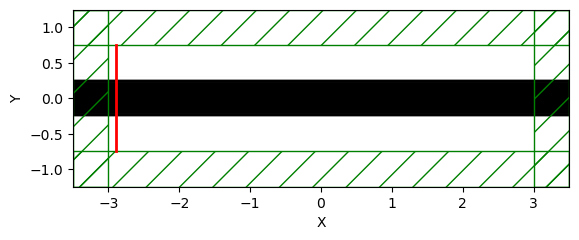

In [5]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(z=0),
        size = mp.Vector3(x=Sx,y=Sy)
    ))

<Axes: xlabel='X', ylabel='Z'>

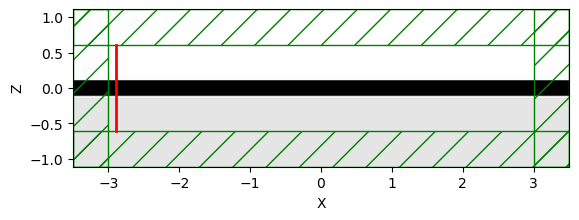

In [6]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(y=0),
        size = mp.Vector3(x=Sx,z=Sz)))

<Axes: xlabel='Y', ylabel='Z'>

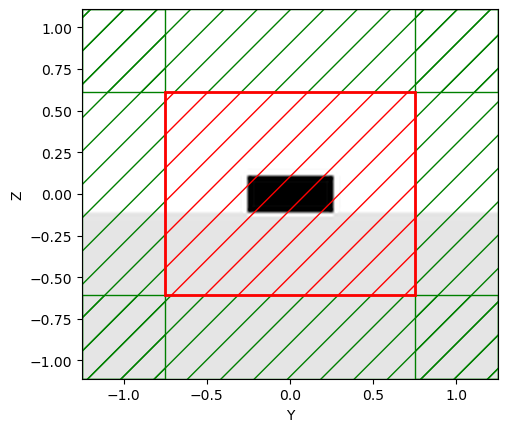

In [7]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(x=-Sx/2 + pml_size + 0.1),
        size = mp.Vector3(y=Sy, z=Sz)
    ))

In [8]:
sim.run(until=300)


### Ey for TE polarization

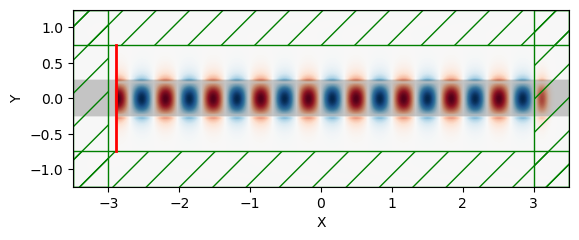

In [9]:
plt.figure(dpi=100)
sim.plot2D(fields= mp.Ey,
    output_plane = mp.Volume(
        center = mp.Vector3(z=0.0),
        size = mp.Vector3(x=Sx,y=Sy, z=0)
    ))
plt.show()

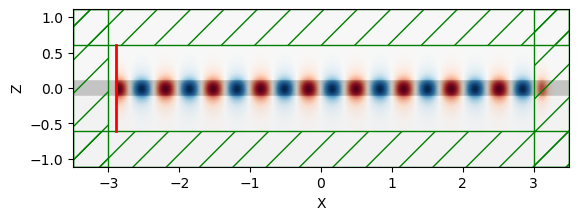

In [10]:
plt.figure(dpi=100)
sim.plot2D(fields= mp.Ey,
    output_plane = mp.Volume(
        center = mp.Vector3(y=0.0),
        size = mp.Vector3(x=Sx,z=Sz)))
plt.show()

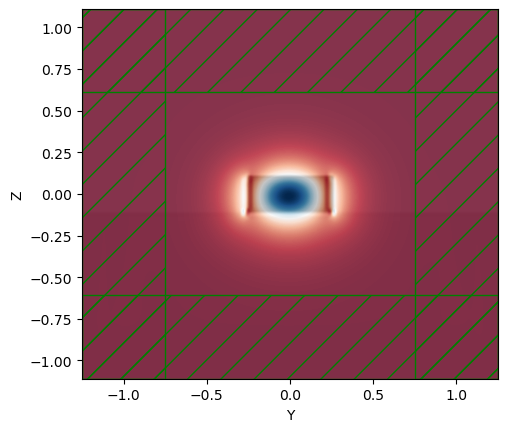

In [11]:
plt.figure(dpi=100)
sim.plot2D(fields= mp.Ey,
    output_plane = mp.Volume(
        center = mp.Vector3(x=0.1), ## if x=0 then its the mid point hence no waveguide
        size = mp.Vector3(y=Sy, z=Sz)
    ))
plt.show()

### For 2D cell simulation

In [12]:
eig_sources = [mp.EigenModeSource(src=mp.ContinuousSource(fcen, fwidth=0.1*fcen),
                                    size=source_size,
                                    center=[0,0,0],
                                    eig_band=1,
                                    eig_kpoint=kpoint)]





sim = mp.Simulation(cell_size=mp.Vector3(0,Sy,Sz),
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=eig_sources,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution,
                    eps_averaging = True)

<Axes: xlabel='Y', ylabel='Z'>

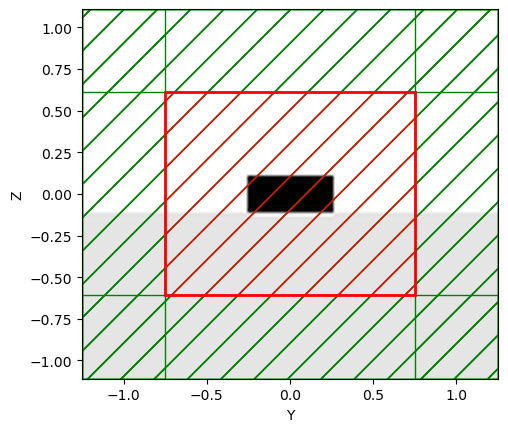

In [13]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(x=0),
        size = mp.Vector3(y=Sy, z=Sz)
    ))

In [14]:
sim.run(until=200)


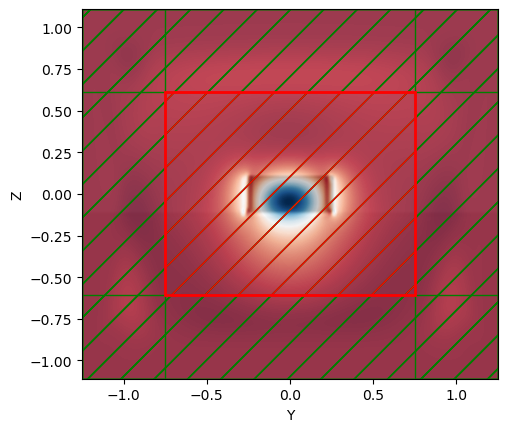

In [15]:
plt.figure(dpi=100)
sim.plot2D(fields= mp.Ey,
    output_plane = mp.Volume(
        center = mp.Vector3(x=0.0), ## if x=0 then its the mid point hence no waveguide
        size = mp.Vector3(y=Sy, z=Sz)
    ))
plt.show()

In [16]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ey,  realtime=False, normalize=True)
plt.close()

<Figure size 640x480 with 0 Axes>

In [17]:
sim.run(mp.at_every(1, Animate), until=200)
plt.close()

In [18]:
filename = "strip_waveguides_2d_cell.mp4"
Animate.to_mp4(10, filename)

In [19]:
Video(filename)


## Rib waveguide

In [20]:
import meep as mp
print(mp.__version__)
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt
from IPython.display import Video

1.27.0


In [21]:
seed = np.random.randint(100000)
np.random.seed(seed)
mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)
Air = mp.Medium(index=1.0)




waveguide_width = 0.5 # (μm)
waveguide_length = 6 # (μm)
waveguide_thickness = 0.22

arm_separation =waveguide_width+ 0.5 # (μm) distance between arms center to center

air_cladding=200 # just some large value
soi_cladding=200

d=0.07
rib_thickness=waveguide_thickness-d
rib_width=1

pml_size = 0.5 # (μm)
resolution = 50 # (pixels/μm)

In [22]:
minimum_length = 0.09 # (μm)
eta_e = 0.75

eta_i = 0.5
eta_d = 1-eta_e
design_region_resolution = int(resolution) # (pixels/μm)
frequencies = 1/np.linspace(1.5,1.6,5) # (1/μm)


In [23]:
Sx = 2*pml_size + waveguide_length # cell size in X
#Sy = 2*pml_size + 2*waveguide_width+ arm_separation +1 # cell size in Y
Sy = 2*pml_size + waveguide_width +1 # cell size in Y

Sz = 2*pml_size + waveguide_thickness +1 # cell size in Z ###

cell_size = mp.Vector3(Sx,Sy,Sz)

pml_layers = [mp.PML(pml_size)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
#source_center  = [-Sx/2 + pml_size + waveguide_length/3,arm_separation/2,0]
#source_size    = mp.Vector3(0,waveguide_width+0.5,waveguide_thickness+0.5)###
#source_size = mp.Vector3(0,2*waveguide_width,2*waveguide_thickness)
source_size= mp.Vector3(0,Sy-2*pml_size,Sz-2*pml_size)
kpoint = mp.Vector3(1,0,0)

#source_center1  = [-Sx/2 + pml_size + 0.1 ,arm_separation/2,0]

source_center1  = [-Sx/2 + pml_size + 0.1 ,0,0]
source_center2  = [-Sx/2 + pml_size + 0.1,-arm_separation/2,0]

# src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
# sources = [mp.EigenModeSource(src,
#                     eig_band = 1,
#                     direction=mp.NO_DIRECTION,
#                     eig_kpoint=kpoint,
#                     size = source_size,
#                     center=source_center1,
#                     amplitude=1.0),
#             mp.EigenModeSource(
#                     src,
#                     eig_band=1,
#                     direction=mp.NO_DIRECTION,
#                     eig_kpoint=kpoint,
#                     size=source_size,
#                     center=source_center2,
#                     amplitude=0.0 - 1.0j
#     )]


source=[mp.EigenModeSource(mp.ContinuousSource(fcen, fwidth=fwidth), center=source_center1, size=source_size, eig_band=1,direction=mp.NO_DIRECTION,eig_kpoint=kpoint)]




geometry=[]

# the top and bottom cladding
geometry.append(mp.Block(center=mp.Vector3(0, 0, -(waveguide_thickness+soi_cladding)/2), material=SiO2, size=mp.Vector3(mp.inf, mp.inf, soi_cladding))) #Oxide layer
geometry.append(mp.Block(center=mp.Vector3(0, 0, (-waveguide_thickness+air_cladding)/2), material=Air, size=mp.Vector3(mp.inf, mp.inf, air_cladding))) #the air cladding

# the waveguides
geometry.append(mp.Block(center=mp.Vector3(), material=Si, size=mp.Vector3(mp.inf, waveguide_width, waveguide_thickness))) # top left waveguide
geometry.append(mp.Block(center=mp.Vector3(0,0,-d/2), material=Si, size=mp.Vector3(mp.inf, rib_width, rib_thickness))) # top left waveguide


sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution,
                    eps_averaging = True,)

  

<Axes: xlabel='X', ylabel='Y'>

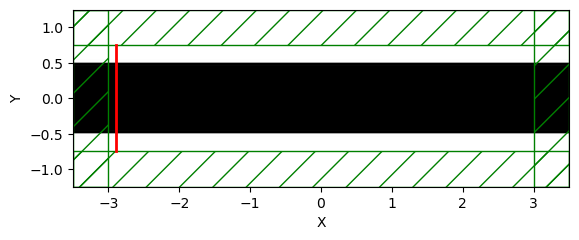

In [24]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(z=0),
        size = mp.Vector3(x=Sx,y=Sy)
    ))

<Axes: xlabel='X', ylabel='Z'>

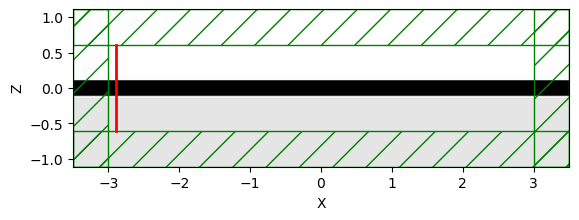

In [25]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(y=0),
        size = mp.Vector3(x=Sx,z=Sz)))

<Axes: xlabel='Y', ylabel='Z'>

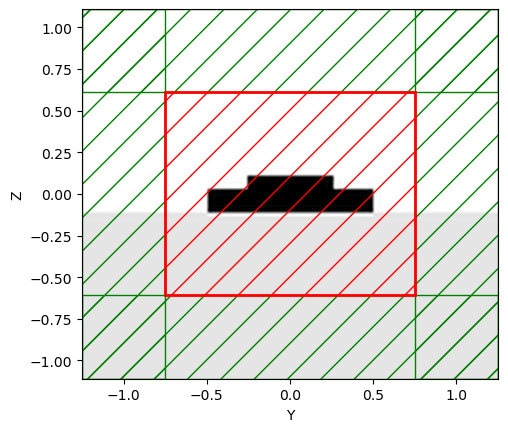

In [26]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(x=-Sx/2 + pml_size + 0.1),
        size = mp.Vector3(y=Sy, z=Sz)
    ))

In [27]:
sim.run(until=300)


### Ey for TE polarization

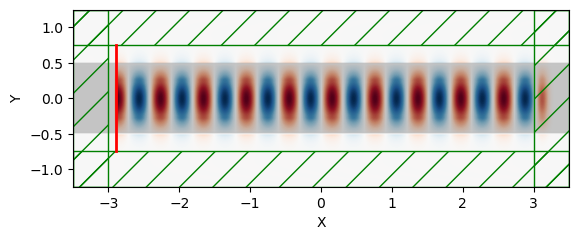

In [28]:
plt.figure(dpi=100)
sim.plot2D(fields= mp.Ey,
    output_plane = mp.Volume(
        center = mp.Vector3(z=0.0),
        size = mp.Vector3(x=Sx,y=Sy, z=0)
    ))
plt.show()

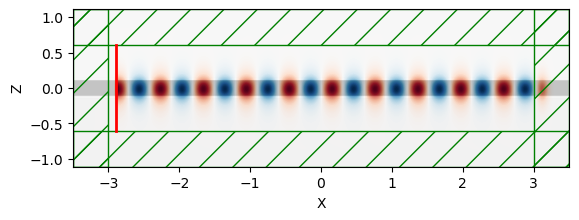

In [29]:
plt.figure(dpi=100)
sim.plot2D(fields= mp.Ey,
    output_plane = mp.Volume(
        center = mp.Vector3(y=0.0),
        size = mp.Vector3(x=Sx,z=Sz)))
plt.show()

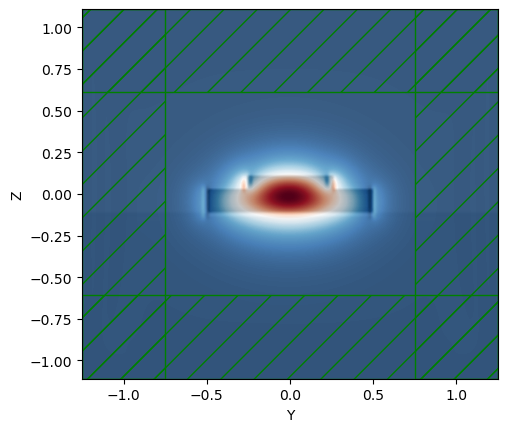

In [30]:
plt.figure(dpi=100)
sim.plot2D(fields= mp.Ey,
    output_plane = mp.Volume(
        center = mp.Vector3(x=0.1), ## if x=0 then its the mid point hence no waveguide
        size = mp.Vector3(y=Sy, z=Sz)
    ))
plt.show()

### For 2D cell simulation

In [31]:
eig_sources = [mp.EigenModeSource(src=mp.ContinuousSource(fcen, fwidth=0.1*fcen),
                                    size=source_size,
                                    center=[0,0,0],
                                    eig_band=1,
                                    eig_kpoint=kpoint)]





sim = mp.Simulation(cell_size=mp.Vector3(0,Sy,Sz),
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=eig_sources,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution,
                    eps_averaging = True)

<Axes: xlabel='Y', ylabel='Z'>

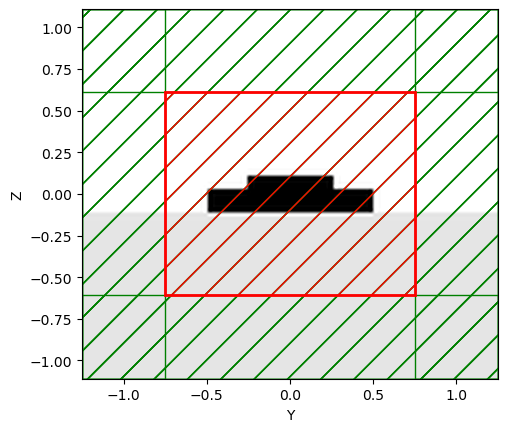

In [32]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(x=0),
        size = mp.Vector3(y=Sy, z=Sz)
    ))

In [33]:
sim.run(until=200)


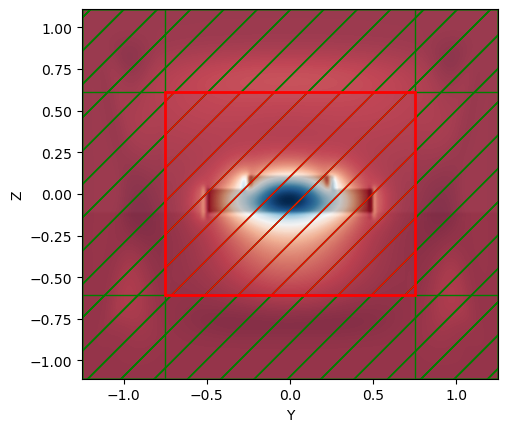

In [34]:
plt.figure(dpi=100)
sim.plot2D(fields= mp.Ey,
    output_plane = mp.Volume(
        center = mp.Vector3(x=0.0), ## if x=0 then its the mid point hence no waveguide
        size = mp.Vector3(y=Sy, z=Sz)
    ))
plt.show()

In [35]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ey,  realtime=False, normalize=True)
plt.close()

<Figure size 640x480 with 0 Axes>

In [36]:
sim.run(mp.at_every(1, Animate), until=200)
plt.close()

In [37]:
filename = "rib_waveguides_2d_cell.mp4"
Animate.to_mp4(10, filename)

In [38]:
Video(filename)


## Strip waveguide with sidewalls

In [39]:
import meep as mp
print(mp.__version__)
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt
from IPython.display import Video

1.27.0


In [66]:
seed = np.random.randint(100000)
np.random.seed(seed)
mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)
Air = mp.Medium(index=1.0)




waveguide_width = 0.5 # (μm)
waveguide_length = 6 # (μm)
waveguide_thickness = 0.22

arm_separation =waveguide_width+ 0.5 # (μm) distance between arms center to center

air_cladding=200 # just some large value
soi_cladding=200
wg_angle=np.pi/6
wg_a=200


pml_size = 0.5 # (μm)
resolution = 50 # (pixels/μm)

In [67]:
minimum_length = 0.09 # (μm)
eta_e = 0.75

eta_i = 0.5
eta_d = 1-eta_e
design_region_resolution = int(resolution) # (pixels/μm)
frequencies = 1/np.linspace(1.5,1.6,5) # (1/μm)


In [68]:
Sx = 2*pml_size + waveguide_length # cell size in X
#Sy = 2*pml_size + 2*waveguide_width+ arm_separation +1 # cell size in Y
Sy = 2*pml_size + waveguide_width +1 # cell size in Y

Sz = 2*pml_size + waveguide_thickness +1 # cell size in Z ###

cell_size = mp.Vector3(Sx,Sy,Sz)

pml_layers = [mp.PML(pml_size)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
#source_center  = [-Sx/2 + pml_size + waveguide_length/3,arm_separation/2,0]
#source_size    = mp.Vector3(0,waveguide_width+0.5,waveguide_thickness+0.5)###
#source_size = mp.Vector3(0,2*waveguide_width,2*waveguide_thickness)
source_size= mp.Vector3(0,Sy-2*pml_size,Sz-2*pml_size)
kpoint = mp.Vector3(1,0,0)

#source_center1  = [-Sx/2 + pml_size + 0.1 ,arm_separation/2,0]

source_center1  = [-Sx/2 + pml_size + 0.1 ,0,0]
source_center2  = [-Sx/2 + pml_size + 0.1,-arm_separation/2,0]

# src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
# sources = [mp.EigenModeSource(src,
#                     eig_band = 1,
#                     direction=mp.NO_DIRECTION,
#                     eig_kpoint=kpoint,
#                     size = source_size,
#                     center=source_center1,
#                     amplitude=1.0),
#             mp.EigenModeSource(
#                     src,
#                     eig_band=1,
#                     direction=mp.NO_DIRECTION,
#                     eig_kpoint=kpoint,
#                     size=source_size,
#                     center=source_center2,
#                     amplitude=0.0 - 1.0j
#     )]


source=[mp.EigenModeSource(mp.ContinuousSource(fcen, fwidth=fwidth), center=source_center1, size=source_size, eig_band=1,direction=mp.NO_DIRECTION,eig_kpoint=kpoint)]




geometry=[]

# the top and bottom cladding
geometry.append(mp.Block(center=mp.Vector3(0, 0, -(waveguide_thickness+soi_cladding)/2), material=SiO2, size=mp.Vector3(mp.inf, mp.inf, soi_cladding))) #Oxide layer
geometry.append(mp.Block(center=mp.Vector3(0, 0, (-waveguide_thickness+air_cladding)/2), material=Air, size=mp.Vector3(mp.inf, mp.inf, air_cladding))) #the air cladding


# prims not working, idk why

# vertices = [mp.Vector3(0,waveguide_width/2,-waveguide_thickness/2),
#             mp.Vector3(0,-waveguide_width/2,-waveguide_thickness/2),
#             mp.Vector3(0,-waveguide_width/2+np.tan(wg_angle)*waveguide_thickness,waveguide_thickness/2),
#             mp.Vector3(0,waveguide_width/2-np.tan(wg_angle)*waveguide_thickness,waveguide_thickness/2),
#             ]

# geometry.append(mp.Prism(vertices, height=mp.inf, center=mp.Vector3(), material=Si, axis=mp.Vector3(1,0,0)))

###################################################################################################################################################

# the waveguides
h=0
while (h <= waveguide_thickness):
    geometry.append(mp.Block(center=mp.Vector3(0,0,-waveguide_thickness/2+h), material=Si, size=mp.Vector3(mp.inf, waveguide_width-2*h*np.tan(wg_angle), 1/resolution))) # top left waveguide
    h=h+1/(2*resolution)


###################################################################################################################################################

# geometry.append(mp.Block(center=mp.Vector3(), material=Si, size=mp.Vector3(mp.inf, waveguide_width, waveguide_thickness))) 

# pvec_right=mp.Vector3(0,waveguide_width/2,-waveguide_thickness/2)
# pvec_left=mp.Vector3(0,-waveguide_width/2,-waveguide_thickness/2)
# cvec_right=mp.Vector3(0,(waveguide_width+wg_a)/2,(wg_a-waveguide_thickness)/2)
# cvec_left=mp.Vector3(0,-(waveguide_width+wg_a)/2,(wg_a-waveguide_thickness)/2)

# rvec_right=cvec_right-pvec_right
# rvec_left=cvec_left-pvec_left

# rrvec_right=rvec_right.rotate(mp.Vector3(1,0,0),wg_angle)
# rrvec_left=rvec_left.rotate(mp.Vector3(1,0,0),-wg_angle)

# geometry.append(mp.Block(material=mp.air, center=pvec_right+rrvec_right, size=mp.Vector3(mp.inf,wg_a,wg_a),
#                          e1=mp.Vector3(1,0,0),
#                          e2=mp.Vector3(0,1,0).rotate(mp.Vector3(1,0,0),wg_angle),
#                          e3=mp.Vector3(0,0,1).rotate(mp.Vector3(1,0,0),wg_angle)))

# geometry.append(mp.Block(material=mp.air, center=pvec_left+rrvec_left, size=mp.Vector3(mp.inf,wg_a,wg_a),
#                          e1=mp.Vector3(1,0,0),
#                          e2=mp.Vector3(0,1,0).rotate(mp.Vector3(1,0,0),-wg_angle),
#                          e3=mp.Vector3(0,0,1).rotate(mp.Vector3(1,0,0),-wg_angle)))

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution,
                    eps_averaging = True,)

  

<Axes: xlabel='X', ylabel='Y'>

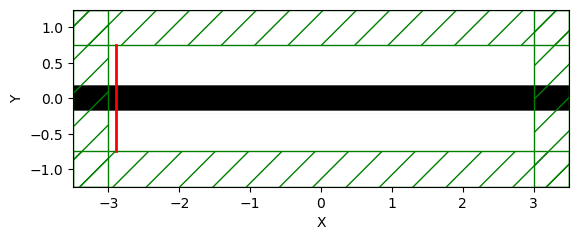

In [69]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(z=0),
        size = mp.Vector3(x=Sx,y=Sy)
    ))

<Axes: xlabel='X', ylabel='Z'>

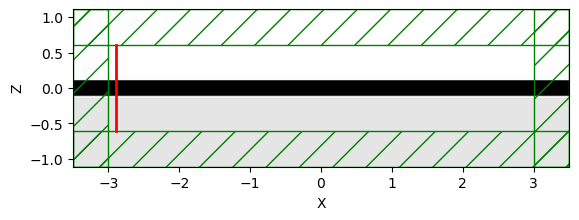

In [70]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(y=0),
        size = mp.Vector3(x=Sx,z=Sz)))

<Axes: xlabel='Y', ylabel='Z'>

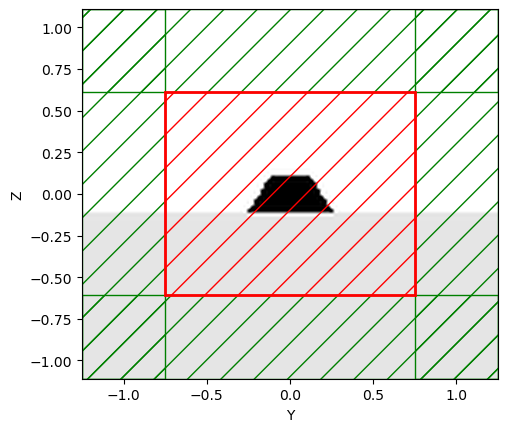

In [71]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(x=-Sx/2 + pml_size + 0.1),
        size = mp.Vector3(y=Sy, z=Sz)
    ))

### geometry with blocks

<Axes: xlabel='Y', ylabel='Z'>

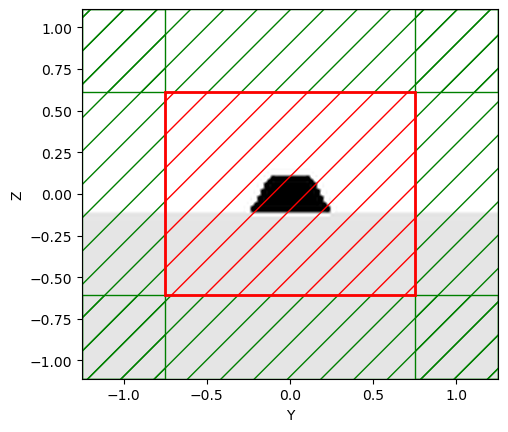

In [72]:

geometry=[]

# the top and bottom cladding
geometry.append(mp.Block(center=mp.Vector3(0, 0, -(waveguide_thickness+soi_cladding)/2), material=SiO2, size=mp.Vector3(mp.inf, mp.inf, soi_cladding))) #Oxide layer
geometry.append(mp.Block(center=mp.Vector3(0, 0, (-waveguide_thickness+air_cladding)/2), material=Air, size=mp.Vector3(mp.inf, mp.inf, air_cladding))) #the air cladding

geometry.append(mp.Block(center=mp.Vector3(), material=Si, size=mp.Vector3(mp.inf, waveguide_width, waveguide_thickness))) 

pvec_right=mp.Vector3(0,waveguide_width/2,-waveguide_thickness/2)
pvec_left=mp.Vector3(0,-waveguide_width/2,-waveguide_thickness/2)
cvec_right=mp.Vector3(0,(waveguide_width+wg_a)/2,(wg_a-waveguide_thickness)/2)
cvec_left=mp.Vector3(0,-(waveguide_width+wg_a)/2,(wg_a-waveguide_thickness)/2)

rvec_right=cvec_right-pvec_right
rvec_left=cvec_left-pvec_left

rrvec_right=rvec_right.rotate(mp.Vector3(1,0,0),wg_angle)
rrvec_left=rvec_left.rotate(mp.Vector3(1,0,0),-wg_angle)

geometry.append(mp.Block(material=mp.air, center=pvec_right+rrvec_right, size=mp.Vector3(mp.inf,wg_a,wg_a),
                         e1=mp.Vector3(1,0,0),
                         e2=mp.Vector3(0,1,0).rotate(mp.Vector3(1,0,0),wg_angle),
                         e3=mp.Vector3(0,0,1).rotate(mp.Vector3(1,0,0),wg_angle)))

geometry.append(mp.Block(material=mp.air, center=pvec_left+rrvec_left, size=mp.Vector3(mp.inf,wg_a,wg_a),
                         e1=mp.Vector3(1,0,0),
                         e2=mp.Vector3(0,1,0).rotate(mp.Vector3(1,0,0),-wg_angle),
                         e3=mp.Vector3(0,0,1).rotate(mp.Vector3(1,0,0),-wg_angle)))

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution,
                    eps_averaging = True,)


sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(x=-Sx/2 + pml_size + 0.1),
        size = mp.Vector3(y=Sy, z=Sz)
    ))

### Continue

In [73]:
sim.run(until=300)


### Ey for TE polarization

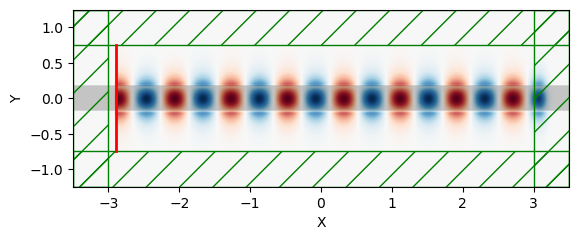

In [74]:
plt.figure(dpi=100)
sim.plot2D(fields= mp.Ey,
    output_plane = mp.Volume(
        center = mp.Vector3(z=0.0),
        size = mp.Vector3(x=Sx,y=Sy, z=0)
    ))
plt.show()

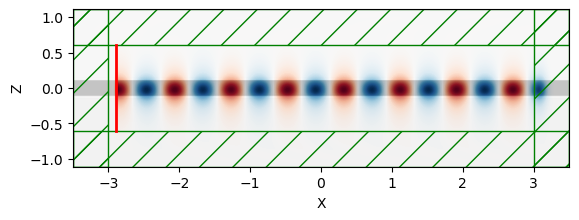

In [75]:
plt.figure(dpi=100)
sim.plot2D(fields= mp.Ey,
    output_plane = mp.Volume(
        center = mp.Vector3(y=0.0),
        size = mp.Vector3(x=Sx,z=Sz)))
plt.show()

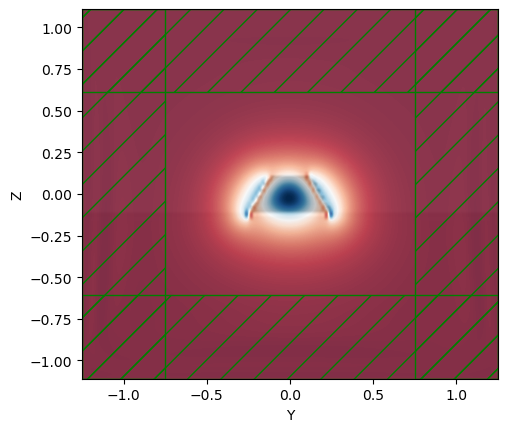

In [76]:
plt.figure(dpi=100)
sim.plot2D(fields= mp.Ey,
    output_plane = mp.Volume(
        center = mp.Vector3(x=2.4), ## if x=0 then its the mid point hence no waveguide
        size = mp.Vector3(y=Sy, z=Sz)
    ))
plt.show()

### For 2D cell simulation

In [77]:
eig_sources = [mp.EigenModeSource(src=mp.ContinuousSource(fcen, fwidth=0.1*fcen),
                                    size=source_size,
                                    center=[0,0,0],
                                    eig_band=1,
                                    eig_kpoint=kpoint)]





sim = mp.Simulation(cell_size=mp.Vector3(0,Sy,Sz),
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=eig_sources,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution,
                    eps_averaging = True)

<Axes: xlabel='Y', ylabel='Z'>

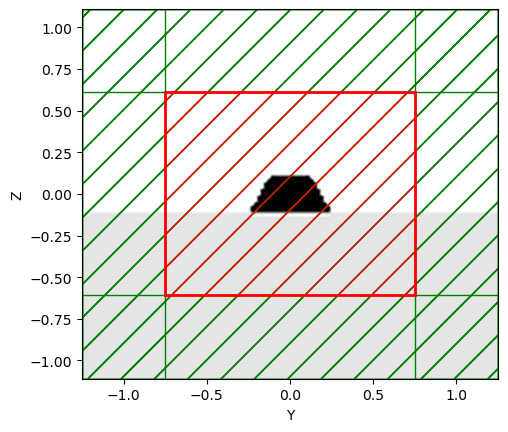

In [78]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(x=0),
        size = mp.Vector3(y=Sy, z=Sz)
    ))

In [79]:
sim.run(until=200)


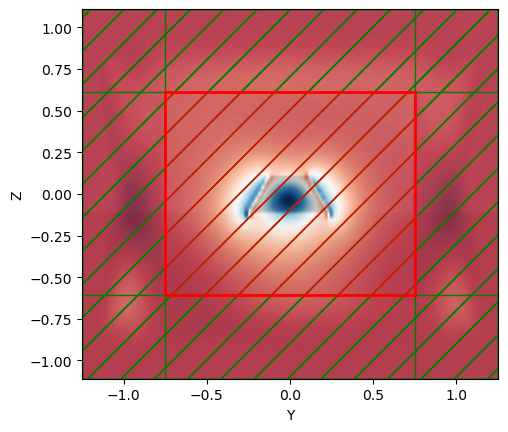

In [80]:
plt.figure(dpi=100)
sim.plot2D(fields= mp.Ey,
    output_plane = mp.Volume(
        center = mp.Vector3(x=0.0), ## if x=0 then its the mid point hence no waveguide
        size = mp.Vector3(y=Sy, z=Sz)
    ))
plt.show()

In [81]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ey,  realtime=False, normalize=True)
plt.close()

<Figure size 640x480 with 0 Axes>

In [82]:
sim.run(mp.at_every(1, Animate), until=200)
plt.close()

In [83]:
filename = "strip_waveguides_sidewall_angles_2d_cell.mp4"
Animate.to_mp4(10, filename)

In [84]:
Video(filename)
